## Figure 4c

Precision @ 10 plots

In [1]:
import glob
import numpy as np
import torch
import scanpy as sc
import pandas as pd 
import copy
import sys
sys.path.append('../../gears_misc/')
import os

from gears.inference import GIs
import matplotlib.patches as mpatches

# Linear model fitting functions
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from dcor import distance_correlation, partial_distance_correlation
from sklearn.metrics import r2_score
from fig_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = 'cuda:3'
#home_dir = '/dfs/user/yhr/perturb_GNN/pertnet/'
#sys.path.append(home_dir)

GI_names = [k.lower() for k in GIs.keys()]

In [2]:
font = {'family' : 'normal',
        'size'   : 18}

import matplotlib
matplotlib.rc('font', **font)

In [3]:
# Filenames
coexp_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/*coexp*.npy')
baseline_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/no_crossgene_baseline/*.npy')
naive_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/naive_seen2.npy')

In [4]:
k = 10
num_samples=1000
dict_ = {}
dict_['cpa'] = {}
dict_['pertnet'] = {}
dict_['naive'] = {}
dict_['gears'] = {}
dfs = {}

In [5]:
for metric in [('eq_contr', 'epistasis'), ('corr_fit', 'neomorphic'), 
               ('dcor', 'redundant'),('mag','suppressor'),
               ('mag','synergy')]:     

    dict_['cpa'][metric[1]] = []
    for idx in [1,3,4]:
        cpa_names = glob.glob('/dfs/user/yhr/CPA_orig/compert/GI_subtypes_out/rep'+str(idx)+'/*.npy')
        p,t,p_names,t_names = get_t_p_seen2(metric[0], cpa_names, return_names=True)
        m, _ = get_prec_atk(p, t, p_names, t_names, GI_type=metric[1], k=k)
        dict_['cpa'][metric[1]].append(m)        

    dict_['pertnet'][metric[1]] = []
    for idx in [4,5,6]:
        crossgene_names = glob.glob('/dfs/user/yhr/snap/perturb_GNN/pertnet-cli/GI_subtypes_out_v'+str(idx)+'/*crossgene*.npy')
        p,t,p_names,t_names = get_t_p_seen2(metric[0], crossgene_names, return_names=True)
        m, _ = get_prec_atk(p, t, p_names, t_names, GI_type=metric[1], k=k)
        dict_['pertnet'][metric[1]].append(m)

    dict_['gears'][metric[1]] = []
    for idx in [1,2,3]:
        all_res_path = '/dfs/user/yhr/gears2/Evaluation/model_ckpt/GI/all_GI_values_seed' + str(idx) + '.npy'
        p,t,p_names,t_names = get_t_p_seen2_gears(metric[0], all_res_path, return_names=True)
        m, _ = get_prec_atk(p, t, p_names, t_names, GI_type=metric[1], k=k)
        dict_['gears'][metric[1]].append(m)
        
    dict_['naive'][metric[1]] = []
    p,t,p_names,t_names = get_t_p_seen2_naive(metric[0], naive_names[0], return_names=True)
    for it in range(num_samples):
        score, _ = get_prec_atk(p, t, p_names, t_names, GI_type=metric[1], k=k, random=True)
        dict_['naive'][metric[1]].append(score)

precision_at_10 = dict_

### Defining thresholds with Other category

In [51]:
np.sort(get_t_p_seen2('mag', crossgene_names, return_names=True)[1]['synergy'])

array([1.14685077, 1.22283352, 1.22374483, 1.29699299, 1.36901979,
       1.39121458, 1.40643537, 1.41980339, 1.42233745, 1.42566483,
       1.44837729, 1.4794279 , 1.4813906 , 1.48142552, 1.48238693,
       1.48591728, 1.4908992 , 1.5040171 , 1.51098667, 1.54303704,
       1.57853654, 1.66771325, 1.67309386, 1.74901558, 1.78204039,
       1.86192267, 1.86304945, 1.89033026, 2.09163154, 2.16035494])

In [22]:
ret = get_t_p_seen2('mag', crossgene_names, return_names=True)[1]
del(ret['synergy'])
vs = np.hstack([v for v in ret.values()])
np.sum(vs>1.15)/len(vs)

0.3816793893129771

In [28]:
ret = get_t_p_seen2('mag', crossgene_names, return_names=True)[1]
del(ret['synergy'])
vs = np.hstack([v for v in ret.values()])
np.sum(vs<1.0)

61

In [29]:
ret = get_t_p_seen2('dcor', crossgene_names, return_names=True)[1]
del(ret['synergy'])
vs = np.hstack([v for v in ret.values()])

np.sum(vs>0.85)

25

In [35]:
ret = get_t_p_seen2('corr_fit', crossgene_names, return_names=True)[1]
del(ret['synergy'])
vs = np.hstack([v for v in ret.values()])

np.sum(vs<0.88)

61

In [31]:
ret = get_t_p_seen2('dominance', crossgene_names, return_names=True)[1]
del(ret['synergy'])
vs = np.hstack([v for v in ret.values()])

np.sum(vs>0.35)

32

In [37]:
ret = get_t_p_seen2('eq_contr', crossgene_names, return_names=True)[1]
del(ret['synergy'])
vs = np.hstack([v for v in ret.values()])

np.sum(vs<0.30)

18

### Defining thresholds without Other category

In [33]:
vs = np.hstack([v for v in get_t_p_seen2('mag', crossgene_names, return_names=True)[1].values()])
np.sum(vs>1.15)/len(vs)

0.4906832298136646

In [58]:
vs = np.hstack([v for v in get_t_p_seen2('mag', crossgene_names, return_names=True)[1].values()])
np.sum(vs<1.0)/len(vs)

0.3135593220338983

In [59]:
vs = np.hstack([v for v in get_t_p_seen2('dcor', crossgene_names, return_names=True)[1].values()])
np.sum(vs>0.85)/len(vs)

0.15254237288135594

In [82]:
vs = np.hstack([v for v in get_t_p_seen2('corr_fit', crossgene_names, return_names=True)[1].values()])
np.sum(vs<0.85)/len(vs)

0.3305084745762712

In [75]:
vs = np.hstack([v for v in get_t_p_seen2('dominance', crossgene_names, return_names=True)[1].values()])
np.sum(vs>0.35)/len(vs)

0.2033898305084746

In [67]:
vs = np.hstack([v for v in get_t_p_seen2('eq_contr', crossgene_names, return_names=True)[1].values()])
np.sum(vs<0.3)/len(vs)

0.11864406779661017

### Make box plot with control 

In [6]:
ticklabel_map = {'synergy': 'Synergy',
                 'suppressor':'Suppression',
                 'neomorphic':'Neomorphism',
                 'redundant':'Redundancy',
                 'epistasis':'Epistasis'}

In [7]:
import numpy as np
import scipy.stats


def CI(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

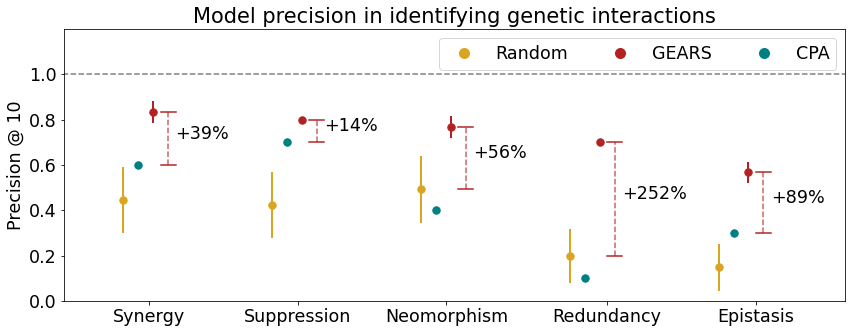

In [10]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 17.5}

matplotlib.rc('font', **font)

legend=True
keys = list(precision_at_10['naive'].keys())
keys = np.sort(list(keys))[::-1]
keys = ['synergy', 'suppressor', 'neomorphic', 'redundant', 'epistasis']
naive_values = [precision_at_10['naive'][k] for k in keys]

medianprops = dict(color='black')
fig = plt.figure(figsize=[14,5])

keys_ = [ticklabel_map[x] for x in keys]

plt.plot([0,5+1.75],[1,1], color='black', linestyle='--', alpha=0.5)

for it, k in enumerate(keys):
    plt.scatter(it+1-0.1, np.mean(naive_values[it]), marker='.', 
                s=220, color='goldenrod')
    box = plt.errorbar(it+1-0.1, np.mean(naive_values[it]),  
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(naive_values[it]), color='goldenrod')
    box = plt.errorbar(it+1+0.1, np.mean(precision_at_10['gears'][k]), 
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(precision_at_10['gears'][k]), color='firebrick')
    plt.scatter(it+1+0.1, np.mean(precision_at_10['gears'][k]), marker='.', 
                s=220, color='firebrick')
    
    # Annotation
    line_bot = np.max([np.mean(precision_at_10['cpa'][k]), np.mean(precision_at_10['naive'][k])])
    line_top = np.mean(precision_at_10['gears'][k])
    text_pos = (line_bot + line_top)/2
    improve = (line_top-line_bot)/line_bot * 100
    plt.plot([it+1+0.2,it+1+0.2],[line_bot,line_top], color='firebrick', 
                          linestyle='--', alpha=0.7)
    plt.annotate('+{0:.0f}%'.format(improve),(it+1.25, text_pos))
    plt.plot([it+1.15,it+1.25],[line_top,line_top], color='firebrick')
    plt.plot([it+1.15,it+1.25],[line_bot,line_bot], color='firebrick')
    plt.scatter(it+1, np.mean(precision_at_10['cpa'][k]), marker='.', 
                s=220, color='teal')
    box = plt.errorbar(it+1, np.mean(precision_at_10['cpa'][k]), 
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(precision_at_10['cpa'][k]), color='teal')
    
plt.ylim([-0.1,1])
plt.ylabel('Precision @ 10')

yellow_dot = plt.Line2D((0,1),(0,0), color='goldenrod', marker='.', 
                       markersize=20, linestyle='', label='Random')
red_dot = plt.Line2D((0,1),(0,0), color='firebrick', marker='.', 
                       markersize=20, linestyle='', label='GEARS')
blue_dot = plt.Line2D((0,1),(0,0), color='teal', marker='.',markersize=20,
                       linestyle='', label='CPA')

if legend:
    plt.legend(handles=[yellow_dot, red_dot, blue_dot], 
               bbox_to_anchor=(1.0, 1.0), ncol=3)

plt.title('Model precision in identifying genetic interactions')
_ = plt.xticks([1.07,2.07,3.07,4.15,5.15], keys_)
_ = plt.yticks(np.arange(0,1.1,0.2))
#_ = plt.xticks(np.arange(1,it+2), '')


plt.xlim([0.5,it+1.75])
#plt.xlabel('Genetic Interaction Type')
plt.ylim([0,1.2])

plt.savefig('fig 4c.svg', bbox_inches='tight')

## Top 10 accuracy

In [31]:
k = 10
num_samples=1000
dict_ = {}
dict_['cpa'] = {}
dict_['gears'] = {}
dict_['naive'] = {}
dfs = {}

for metric in [('eq_contr', 'epistasis', 'min'), ('corr_fit', 'neomorphic', 'min'), 
               ('dcor', 'redundant', 'max'),('mag','suppressor', 'min'),
               ('mag','synergy', 'max')]:     

    dict_['cpa'][metric[1]] = []
    for idx in [1,3,4]:
        cpa_names = glob.glob('/dfs/user/yhr/CPA_orig/compert/GI_subtypes_out/rep'+str(idx)+'/*.npy')
        p,t,p_names,t_names = get_t_p_seen2(metric[0], cpa_names, return_names=True)
        m  = get_topk_acc(p, t, p_names, t_names, min_max=metric[2], k=k)
        dict_['cpa'][metric[1]].append(m)        

    dict_['gears'][metric[1]] = []
    for idx in [1,2,3]:
        all_res_path = '/dfs/user/yhr/gears2/Evaluation/model_ckpt/GI/all_GI_values_seed' + str(idx) + '.npy'
        p,t,p_names,t_names = get_t_p_seen2_gears(metric[0], all_res_path, return_names=True)
        m = get_topk_acc(p, t, p_names, t_names, min_max=metric[2], k=k)
        dict_['gears'][metric[1]].append(m)
        
    dict_['naive'][metric[1]] = []
    p,t,p_names,t_names = get_t_p_seen2_naive(metric[0], naive_names[0], return_names=True)
    for it in range(num_samples):
        score = get_topk_acc(p, t, p_names, t_names, min_max=metric[2], k=k, random=True)
        dict_['naive'][metric[1]].append(score)

top_10_acc = dict_

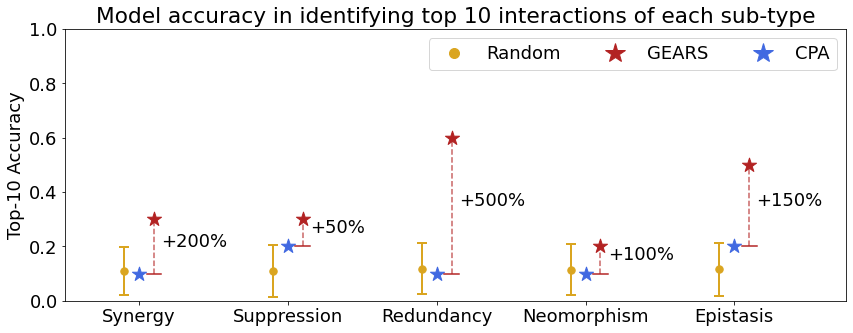

In [14]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

legend=True
keys = list(top_10_acc['naive'].keys())
keys = np.sort(list(keys))[::-1]
naive_values = [top_10_acc['naive'][k] for k in keys]

medianprops = dict(color='black')
fig = plt.figure(figsize=[14,5])

keys_ = [ticklabel_map[x] for x in keys]

for it, k in enumerate(keys):
    plt.scatter(it+1-0.1, np.mean(naive_values[it]), marker='.', 
                s=220, color='goldenrod')
    box = plt.errorbar(it+1-0.1, np.mean(naive_values[it]), capsize=5, 
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(naive_values[it]), color='goldenrod')
    plt.scatter(it+1+0.1, top_10_acc['gears'][k], marker='*', 
                s=220, color='firebrick')
    
    # Annotation
    line_bot = top_10_acc['cpa'][k]
    line_top = top_10_acc['gears'][k]
    text_pos = (line_bot + line_top)/2
    improve = (line_top-line_bot)/line_bot * 100
    plt.plot([it+1+0.1,it+1+0.1],[line_bot,line_top], color='firebrick', 
                          linestyle='--', alpha=0.7)
    plt.annotate('+{0:.0f}%'.format(improve),(it+1.15, text_pos))
    plt.plot([it+1.05,it+1.15],[line_bot,line_bot], color='firebrick')
    plt.scatter(it+1, top_10_acc['cpa'][k], marker='*', 
                s=220, color='royalblue')
    
plt.ylim([-0.1,1])
plt.ylabel('Top-10 Accuracy')

yellow_dot = plt.Line2D((0,1),(0,0), color='goldenrod', marker='.', 
                       markersize=20, linestyle='', label='Random')
red_star = plt.Line2D((0,1),(0,0), color='firebrick', marker='*', 
                       markersize=20, linestyle='', label='GEARS')
blue_star = plt.Line2D((0,1),(0,0), color='royalblue', marker='*',markersize=20,
                       linestyle='', label='CPA')

if legend:
    plt.legend(handles=[yellow_dot, red_star, blue_star], 
               bbox_to_anchor=(1.0, 1.0), ncol=3)

plt.title('Model accuracy in identifying top 10 interactions of each sub-type')
_ = plt.xticks(np.arange(1,it+2), keys_)
#plt.xlabel('Genetic Interaction Type')

#_ = plt.xticks(np.arange(1,it+2), ['']*len(keys_))


plt.xlim([0.5,it+1.75])
plt.ylim([0,1.0])

plt.savefig('topk.svg', bbox_inches='tight')

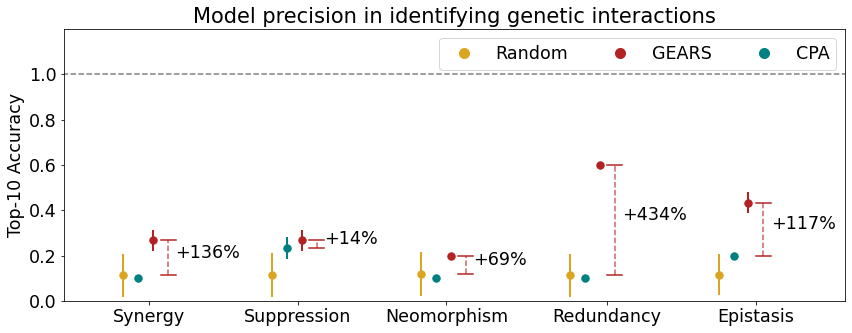

In [32]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 17.5}

matplotlib.rc('font', **font)

legend=True
keys = list(top_10_acc['naive'].keys())
keys = np.sort(list(keys))[::-1]
keys = ['synergy', 'suppressor', 'neomorphic', 'redundant', 'epistasis']
naive_values = [top_10_acc['naive'][k] for k in keys]

medianprops = dict(color='black')
fig = plt.figure(figsize=[14,5])

keys_ = [ticklabel_map[x] for x in keys]

plt.plot([0,5+1.75],[1,1], color='black', linestyle='--', alpha=0.5)

for it, k in enumerate(keys):
    plt.scatter(it+1-0.1, np.mean(naive_values[it]), marker='.', 
                s=220, color='goldenrod')
    box = plt.errorbar(it+1-0.1, np.mean(naive_values[it]),  
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(naive_values[it]), color='goldenrod')
    box = plt.errorbar(it+1+0.1, np.mean(top_10_acc['gears'][k]), 
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(top_10_acc['gears'][k]), color='firebrick')
    plt.scatter(it+1+0.1, np.mean(top_10_acc['gears'][k]), marker='.', 
                s=220, color='firebrick')
    
    # Annotation
    line_bot = np.max([np.mean(top_10_acc['cpa'][k]), np.mean(top_10_acc['naive'][k])])
    line_top = np.mean(top_10_acc['gears'][k])
    text_pos = (line_bot + line_top)/2
    improve = (line_top-line_bot)/line_bot * 100
    plt.plot([it+1+0.2,it+1+0.2],[line_bot,line_top], color='firebrick', 
                          linestyle='--', alpha=0.7)
    plt.annotate('+{0:.0f}%'.format(improve),(it+1.25, text_pos))
    plt.plot([it+1.15,it+1.25],[line_top,line_top], color='firebrick')
    plt.plot([it+1.15,it+1.25],[line_bot,line_bot], color='firebrick')
    plt.scatter(it+1, np.mean(top_10_acc['cpa'][k]), marker='.', 
                s=220, color='teal')
    box = plt.errorbar(it+1, np.mean(top_10_acc['cpa'][k]), 
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(top_10_acc['cpa'][k]), color='teal')
    
plt.ylim([-0.1,1])
plt.ylabel('Top-10 Accuracy')

yellow_dot = plt.Line2D((0,1),(0,0), color='goldenrod', marker='.', 
                       markersize=20, linestyle='', label='Random')
red_dot = plt.Line2D((0,1),(0,0), color='firebrick', marker='.', 
                       markersize=20, linestyle='', label='GEARS')
blue_dot = plt.Line2D((0,1),(0,0), color='teal', marker='.',markersize=20,
                       linestyle='', label='CPA')

if legend:
    plt.legend(handles=[yellow_dot, red_dot, blue_dot], 
               bbox_to_anchor=(1.0, 1.0), ncol=3)

plt.title('Model precision in identifying genetic interactions')
_ = plt.xticks([1.07,2.07,3.07,4.15,5.15], keys_)
_ = plt.yticks(np.arange(0,1.1,0.2))
#_ = plt.xticks(np.arange(1,it+2), '')


plt.xlim([0.5,it+1.75])
#plt.xlabel('Genetic Interaction Type')
plt.ylim([0,1.2])

plt.savefig('fig 4c.svg', bbox_inches='tight')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


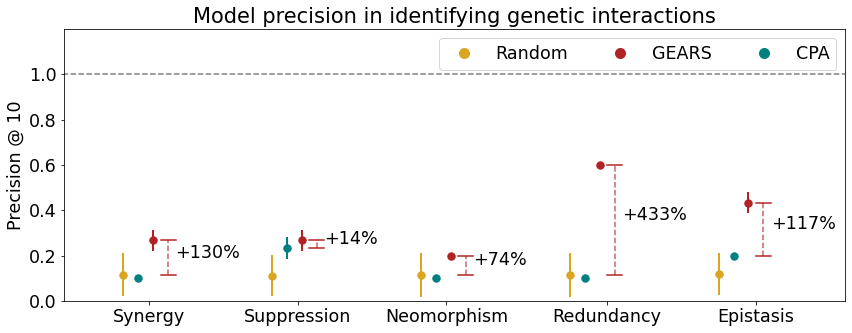

In [28]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 17.5}

matplotlib.rc('font', **font)

legend=True
keys = list(top_10_acc['naive'].keys())
keys = np.sort(list(keys))[::-1]
keys = ['synergy', 'suppressor', 'neomorphic', 'redundant', 'epistasis']
naive_values = [top_10_acc['naive'][k] for k in keys]

medianprops = dict(color='black')
fig = plt.figure(figsize=[14,5])

keys_ = [ticklabel_map[x] for x in keys]

plt.plot([0,5+1.75],[1,1], color='black', linestyle='--', alpha=0.5)

for it, k in enumerate(keys):
    plt.scatter(it+1-0.1, np.mean(naive_values[it]), marker='.', 
                s=220, color='goldenrod')
    box = plt.errorbar(it+1-0.1, np.mean(naive_values[it]),  
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(naive_values[it]), color='goldenrod')
    box = plt.errorbar(it+1+0.1, np.mean(top_10_acc['gears'][k]), 
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(top_10_acc['gears'][k]), color='firebrick')
    plt.scatter(it+1+0.1, np.mean(top_10_acc['gears'][k]), marker='.', 
                s=220, color='firebrick')
    
    # Annotation
    line_bot = np.max([np.mean(top_10_acc['cpa'][k]), np.mean(top_10_acc['naive'][k])])
    line_top = np.mean(top_10_acc['gears'][k])
    text_pos = (line_bot + line_top)/2
    improve = (line_top-line_bot)/line_bot * 100
    plt.plot([it+1+0.2,it+1+0.2],[line_bot,line_top], color='firebrick', 
                          linestyle='--', alpha=0.7)
    plt.annotate('+{0:.0f}%'.format(improve),(it+1.25, text_pos))
    plt.plot([it+1.15,it+1.25],[line_top,line_top], color='firebrick')
    plt.plot([it+1.15,it+1.25],[line_bot,line_bot], color='firebrick')
    plt.scatter(it+1, np.mean(top_10_acc['cpa'][k]), marker='.', 
                s=220, color='teal')
    box = plt.errorbar(it+1, np.mean(top_10_acc['cpa'][k]), 
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(top_10_acc['cpa'][k]), color='teal')
    
plt.ylim([-0.1,1])
plt.ylabel('Top-10 Accuracy')

yellow_dot = plt.Line2D((0,1),(0,0), color='goldenrod', marker='.', 
                       markersize=20, linestyle='', label='Random')
red_dot = plt.Line2D((0,1),(0,0), color='firebrick', marker='.', 
                       markersize=20, linestyle='', label='GEARS')
blue_dot = plt.Line2D((0,1),(0,0), color='teal', marker='.',markersize=20,
                       linestyle='', label='CPA')

if legend:
    plt.legend(handles=[yellow_dot, red_dot, blue_dot], 
               bbox_to_anchor=(1.0, 1.0), ncol=3)

plt.title('Model precision in identifying genetic interactions')
_ = plt.xticks([1.07,2.07,3.07,4.15,5.15], keys_)
_ = plt.yticks(np.arange(0,1.1,0.2))
#_ = plt.xticks(np.arange(1,it+2), '')


plt.xlim([0.5,it+1.75])
#plt.xlabel('Genetic Interaction Type')
plt.ylim([0,1.2])

plt.savefig('fig 4c.svg', bbox_inches='tight')

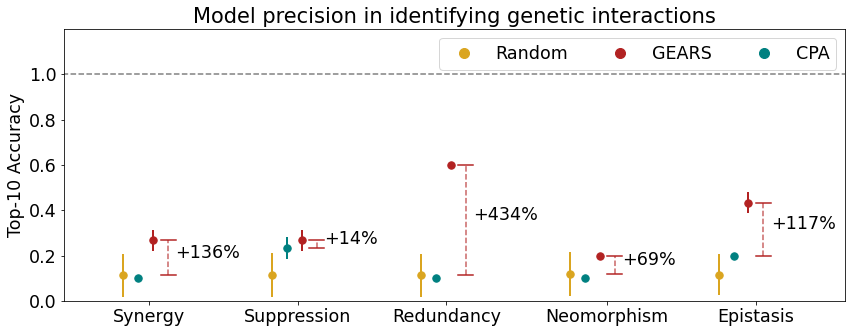

In [121]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 17.5}

matplotlib.rc('font', **font)

legend=True
keys = list(top_10_acc['naive'].keys())
keys = np.sort(list(keys))[::-1]
keys = ['synergy', 'suppressor', 'redundant', 'neomorphic', 'epistasis']
naive_values = [top_10_acc['naive'][k] for k in keys]

medianprops = dict(color='black')
fig = plt.figure(figsize=[14,5])

keys_ = [ticklabel_map[x] for x in keys]

plt.plot([0,5+1.75],[1,1], color='black', linestyle='--', alpha=0.5)

for it, k in enumerate(keys):
    plt.scatter(it+1-0.1, np.mean(naive_values[it]), marker='.', 
                s=220, color='goldenrod')
    box = plt.errorbar(it+1-0.1, np.mean(naive_values[it]),  
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(naive_values[it]), color='goldenrod')
    box = plt.errorbar(it+1+0.1, np.mean(top_10_acc['gears'][k]), 
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(top_10_acc['gears'][k]), color='firebrick')
    plt.scatter(it+1+0.1, np.mean(top_10_acc['gears'][k]), marker='.', 
                s=220, color='firebrick')
    
    # Annotation
    line_bot = np.max([np.mean(top_10_acc['cpa'][k]), np.mean(top_10_acc['naive'][k])])
    line_top = np.mean(top_10_acc['gears'][k])
    text_pos = (line_bot + line_top)/2
    improve = (line_top-line_bot)/line_bot * 100
    plt.plot([it+1+0.2,it+1+0.2],[line_bot,line_top], color='firebrick', 
                          linestyle='--', alpha=0.7)
    plt.annotate('+{0:.0f}%'.format(improve),(it+1.25, text_pos))
    plt.plot([it+1.15,it+1.25],[line_top,line_top], color='firebrick')
    plt.plot([it+1.15,it+1.25],[line_bot,line_bot], color='firebrick')
    plt.scatter(it+1, np.mean(top_10_acc['cpa'][k]), marker='.', 
                s=220, color='teal')
    box = plt.errorbar(it+1, np.mean(top_10_acc['cpa'][k]), 
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(top_10_acc['cpa'][k]), color='teal')
    
plt.ylim([-0.1,1])
plt.ylabel('Top-10 Accuracy')

yellow_dot = plt.Line2D((0,1),(0,0), color='goldenrod', marker='.', 
                       markersize=20, linestyle='', label='Random')
red_dot = plt.Line2D((0,1),(0,0), color='firebrick', marker='.', 
                       markersize=20, linestyle='', label='GEARS')
blue_dot = plt.Line2D((0,1),(0,0), color='teal', marker='.',markersize=20,
                       linestyle='', label='CPA')

if legend:
    plt.legend(handles=[yellow_dot, red_dot, blue_dot], 
               bbox_to_anchor=(1.0, 1.0), ncol=3)

plt.title('Model precision in identifying genetic interactions')
_ = plt.xticks([1.07,2.07,3.07,4.15,5.15], keys_)
_ = plt.yticks(np.arange(0,1.1,0.2))
#_ = plt.xticks(np.arange(1,it+2), '')


plt.xlim([0.5,it+1.75])
#plt.xlabel('Genetic Interaction Type')
plt.ylim([0,1.2])

plt.savefig('fig 4c.svg', bbox_inches='tight')

In [119]:
top_10_acc['cpa']

{'epistasis': [0.2, 0.2, 0.2],
 'neomorphic': [0.1, 0.1, 0.1],
 'redundant': [0.1, 0.1, 0.1],
 'suppressor': [0.3, 0.2, 0.2],
 'synergy': [0.1, 0.1, 0.1]}

In [118]:
top_10_acc['gears']

{'epistasis': [0.4, 0.5, 0.4],
 'neomorphic': [0.2, 0.2, 0.2],
 'redundant': [0.6, 0.6, 0.6],
 'suppressor': [0.3, 0.3, 0.2],
 'synergy': [0.2, 0.3, 0.3]}

In [15]:
from fig_utils import get_all_pr_scores_gears

In [107]:
gears_seen2_dfs = []
for idx in [1,2,3]:
    all_res_path = '/dfs/user/yhr/gears2/Evaluation/model_ckpt/GI/all_GI_values_seed' + str(idx) + '.npy'
    gears_seen2_df = pd.DataFrame(get_all_pr_scores_gears(all_res_path, seen=2))
    #gears_seen2_df = gears_seen2_df.loc[:,['synergy', 'suppressor', 'redundant', 'neomorphic', 'epistatic', 'additive']]
    #gears_seen2_df['model'] = 'GEARS'
    gears_seen2_dfs.append(gears_seen2_df)
    
gears_precision = pd.concat(gears_seen2_dfs).loc['precision'].melt()
gears_precision['model']='GEARS'
gears_recall = pd.concat(gears_seen2_dfs).loc['recall'].melt()
gears_recall['model']='GEARS'
    
cpa_seen2_dfs = []
for idx in [1,3,4]:
    cpa_names = glob.glob('/dfs/user/yhr/CPA_orig/compert/GI_subtypes_out/rep'+str(idx)+'/*.npy')
    cpa_seen2_df = pd.DataFrame(get_all_pr_scores(cpa_names, seen=2))
    #cpa_seen2_df['model'] = 'CPA'
    cpa_seen2_dfs.append(cpa_seen2_df)
    
cpa_precision = pd.concat(cpa_seen2_dfs).loc['precision'].melt()
cpa_precision['model']='CPA'
cpa_recall = pd.concat(cpa_seen2_dfs).loc['recall'].melt()
cpa_recall['model']='CPA'


In [ ]:
ticklabel_map = {'synergy': 'Synergy',
                 'suppressor':'Suppression',
                 'neomorphic':'Neomorphism',
                 'redundant':'Redundancy',
                 'epistasis':'Epistasis',
                 'epistatic':'Epistasis',
                 'additive': 'Additivity'}

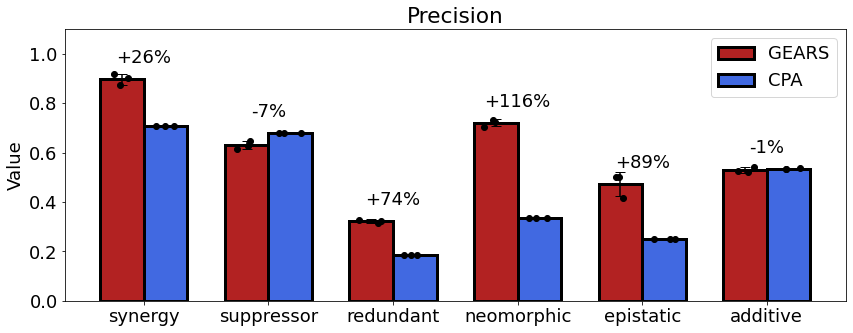

In [115]:
import matplotlib.pyplot as plt
import numpy as np

df_combined = pd.concat([gears_precision, cpa_precision])

fig = plt.figure(figsize=[14, 5])  # Set the figure size

# Group the dataframe by 'variable' and 'model', and calculate the mean value
grouped_data = df_combined.groupby(['variable', 'model'])['value'].mean().unstack()
grouped_data = grouped_data.loc[['synergy', 'suppressor', 'redundant', 'neomorphic', 'epistatic', 'additive']]

# Get the variables and models as x-axis labels
x_labels = grouped_data.index
x = np.arange(len(x_labels))

# Get the values for GEARS and CPA
gears_values = grouped_data['GEARS']
cpa_values = grouped_data['CPA']

# Set the width of each bar
bar_width = 0.35

# Add error bars
for i, (gears_val, cpa_val) in enumerate(zip(gears_values, cpa_values)):
    gears_std = df_combined[(df_combined['variable'] == x_labels[i]) & (df_combined['model'] == 'GEARS')]['value'].std()
    cpa_std = df_combined[(df_combined['variable'] == x_labels[i]) & (df_combined['model'] == 'CPA')]['value'].std()
    
    plt.errorbar(i, gears_val, yerr=gears_std, fmt='none', color='black', capsize=5)
    plt.errorbar(i + bar_width, cpa_val, yerr=cpa_std, fmt='none', color='black', capsize=5)

# Plot the bars for GEARS
bars1 = plt.bar(x, gears_values, width=bar_width, label='GEARS', edgecolor='black', linewidth='3', color='firebrick')

# Plot the bars for CPA
bars2 = plt.bar(x + bar_width, cpa_values, width=bar_width, label='CPA', edgecolor='black', linewidth='3', color='royalblue')

# Set the x-axis ticks and labels
plt.xticks(x + bar_width / 2, x_labels)

# Set the y-axis label
plt.ylabel('Value')

# Set the plot title
plt.title('Precision')

# Add scatter points with jitter
jitter = 0.1
for i, (gears_val, cpa_val) in enumerate(zip(gears_values, cpa_values)):
    gears_data_points = df_combined[(df_combined['variable'] == x_labels[i]) & (df_combined['model'] == 'GEARS')]['value']
    cpa_data_points = df_combined[(df_combined['variable'] == x_labels[i]) & (df_combined['model'] == 'CPA')]['value']
    
    gears_jitter = np.random.uniform(low=-jitter, high=jitter, size=len(gears_data_points))
    cpa_jitter = np.random.uniform(low=-jitter, high=jitter, size=len(cpa_data_points))
    
    plt.scatter(np.full_like(gears_data_points, i) + gears_jitter, gears_data_points, color='black', zorder=10)
    plt.scatter(np.full_like(cpa_data_points, i + bar_width) + cpa_jitter, cpa_data_points, color='black', zorder=10)

    # Annotation
    improvement = (gears_val - cpa_val) / cpa_val * 100
    if improvement > 0:
        text = f'+{improvement:.0f}%'
    else:
        text = f'{improvement:.0f}%'
    plt.text(i + bar_width/2, max(gears_val, cpa_val) + 0.05, text, ha='center', va='bottom')

# Add a legend
plt.legend()
plt.ylim([0,1.1])

# Show the plot
plt.savefig('precision_all.svg')
plt.show()


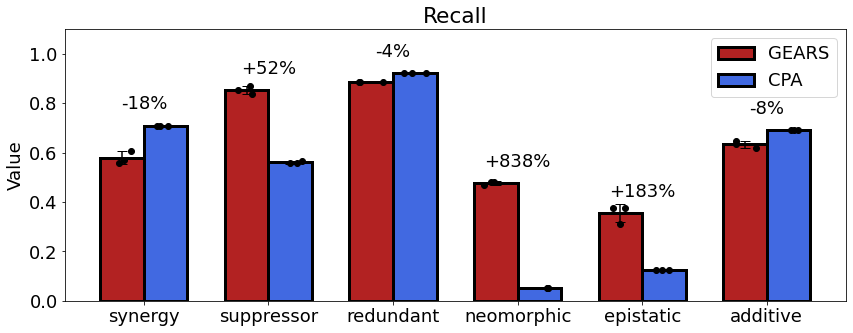

In [116]:
import matplotlib.pyplot as plt
import numpy as np

df_combined = pd.concat([gears_recall, cpa_recall])

fig = plt.figure(figsize=[14, 5])  # Set the figure size

# Group the dataframe by 'variable' and 'model', and calculate the mean value
grouped_data = df_combined.groupby(['variable', 'model'])['value'].mean().unstack()
grouped_data = grouped_data.loc[['synergy', 'suppressor', 'redundant', 'neomorphic', 'epistatic', 'additive']]

# Get the variables and models as x-axis labels
x_labels = grouped_data.index
x = np.arange(len(x_labels))

# Get the values for GEARS and CPA
gears_values = grouped_data['GEARS']
cpa_values = grouped_data['CPA']

# Set the width of each bar
bar_width = 0.35

# Add error bars
for i, (gears_val, cpa_val) in enumerate(zip(gears_values, cpa_values)):
    gears_std = df_combined[(df_combined['variable'] == x_labels[i]) & (df_combined['model'] == 'GEARS')]['value'].std()
    cpa_std = df_combined[(df_combined['variable'] == x_labels[i]) & (df_combined['model'] == 'CPA')]['value'].std()
    
    plt.errorbar(i, gears_val, yerr=gears_std, fmt='none', color='black', capsize=5)
    plt.errorbar(i + bar_width, cpa_val, yerr=cpa_std, fmt='none', color='black', capsize=5)

# Plot the bars for GEARS
bars1 = plt.bar(x, gears_values, width=bar_width, label='GEARS', edgecolor='black', linewidth='3', color='firebrick')

# Plot the bars for CPA
bars2 = plt.bar(x + bar_width, cpa_values, width=bar_width, label='CPA', edgecolor='black', linewidth='3', color='royalblue')

# Set the x-axis ticks and labels
plt.xticks(x + bar_width / 2, x_labels)

# Set the y-axis label
plt.ylabel('Value')

# Set the plot title
plt.title('Recall')

# Add scatter points with jitter
jitter = 0.1
for i, (gears_val, cpa_val) in enumerate(zip(gears_values, cpa_values)):
    gears_data_points = df_combined[(df_combined['variable'] == x_labels[i]) & (df_combined['model'] == 'GEARS')]['value']
    cpa_data_points = df_combined[(df_combined['variable'] == x_labels[i]) & (df_combined['model'] == 'CPA')]['value']
    
    gears_jitter = np.random.uniform(low=-jitter, high=jitter, size=len(gears_data_points))
    cpa_jitter = np.random.uniform(low=-jitter, high=jitter, size=len(cpa_data_points))
    
    plt.scatter(np.full_like(gears_data_points, i) + gears_jitter, gears_data_points, color='black', zorder=10)
    plt.scatter(np.full_like(cpa_data_points, i + bar_width) + cpa_jitter, cpa_data_points, color='black', zorder=10)

    # Annotation
    improvement = (gears_val - cpa_val) / cpa_val * 100
    if improvement > 0:
        text = f'+{improvement:.0f}%'
    else:
        text = f'{improvement:.0f}%'
    plt.text(i + bar_width/2, max(gears_val, cpa_val) + 0.05, text, ha='center', va='bottom')

# Add a legend
plt.legend()
plt.ylim([0,1.1])

# Show the plot
plt.savefig('recall_all.svg')
plt.show()
